In [1]:
%config IPCompleter.greedy=True

In [2]:
import sys
import os
import pandas as pd
sys.path.append("../..") # relative path to module toolkit

In [3]:
#from keras.applications import ResNet50
#from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras_preprocessing.image import ImageDataGenerator
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
# setup
batch_size = 1
val_dir = "../../../images/images_species/test/"
val_images = 1644
datasetDir = "images_species_shuffled_aspect_416/"
saved_model = 'highest_val_acc.h5'
results_file = "results_test.csv"
confusion_matrix_path = './confusion_matrix_norm_test.png'

In [5]:
labels = getLabelsFromDir(val_dir)
val_datagen = ImageDataGenerator(rescale=1./255.)
validation_steps = int(val_images/batch_size) 

In [6]:
model = load_model(saved_model)

In [7]:
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(416, 416),
                                                    shuffle=False,
                                                    seed=1)

Found 1644 images belonging to 200 classes.


In [8]:
Y_pred = model.predict_generator(val_generator, steps=validation_steps, verbose=1)

1644/1644 [==============================] - 47s 28ms/step


In [9]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred3 = [y[-3:] for y in np.argsort(Y_pred, axis=1)] 

In [10]:
def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split(' ')
        row_data = [data for data in row_data if data]
        if len(row_data) > 0:
            row['class'] = row_data[0] + " " + row_data[1]
            row['precision'] = float(row_data[2])
            row['recall'] = float(row_data[3])
            row['f1_score'] = float(row_data[4])
            row['support'] = float(row_data[5])
            report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv('classification_report2_test.csv', index = False)

In [11]:
report = classification_report(val_generator.classes, y_pred, target_names=labels)
classification_report_csv(report)
print(report)

                             precision    recall  f1-score   support

     Philonthus tenuicornis       0.17      0.46      0.25        13
      Paederidus ruficollis       1.00      0.25      0.40        24
       Philonthus splendens       0.33      0.12      0.17        17
    Pseudomedon obscurellus       0.12      1.00      0.21        14
  Staphylinus erythropterus       1.00      0.75      0.86         4
    Lobrathium multipunctum       0.00      0.00      0.00        11
    Philonthus nitidicollis       0.00      0.00      0.00         1
        Xantholinus dvoraki       0.00      0.00      0.00         3
         Lathrobium geminum       0.30      0.67      0.41         9
          Paederus riparius       0.60      1.00      0.75        28
       Heterothops praevius       0.00      0.00      0.00         5
          Gabrius osseticus       0.00      0.00      0.00         6
     Philonthus carbonarius       0.39      0.71      0.51        35
         Quedius semiaeneus      

/home/herri/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Normalized confusion matrix
[[0.46153846 0.         0.         ... 0.         0.         0.        ]
 [0.         0.25       0.         ... 0.         0.04166667 0.        ]
 [0.         0.         0.11764706 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.13333333 0.         0.         ... 0.         0.33333333 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


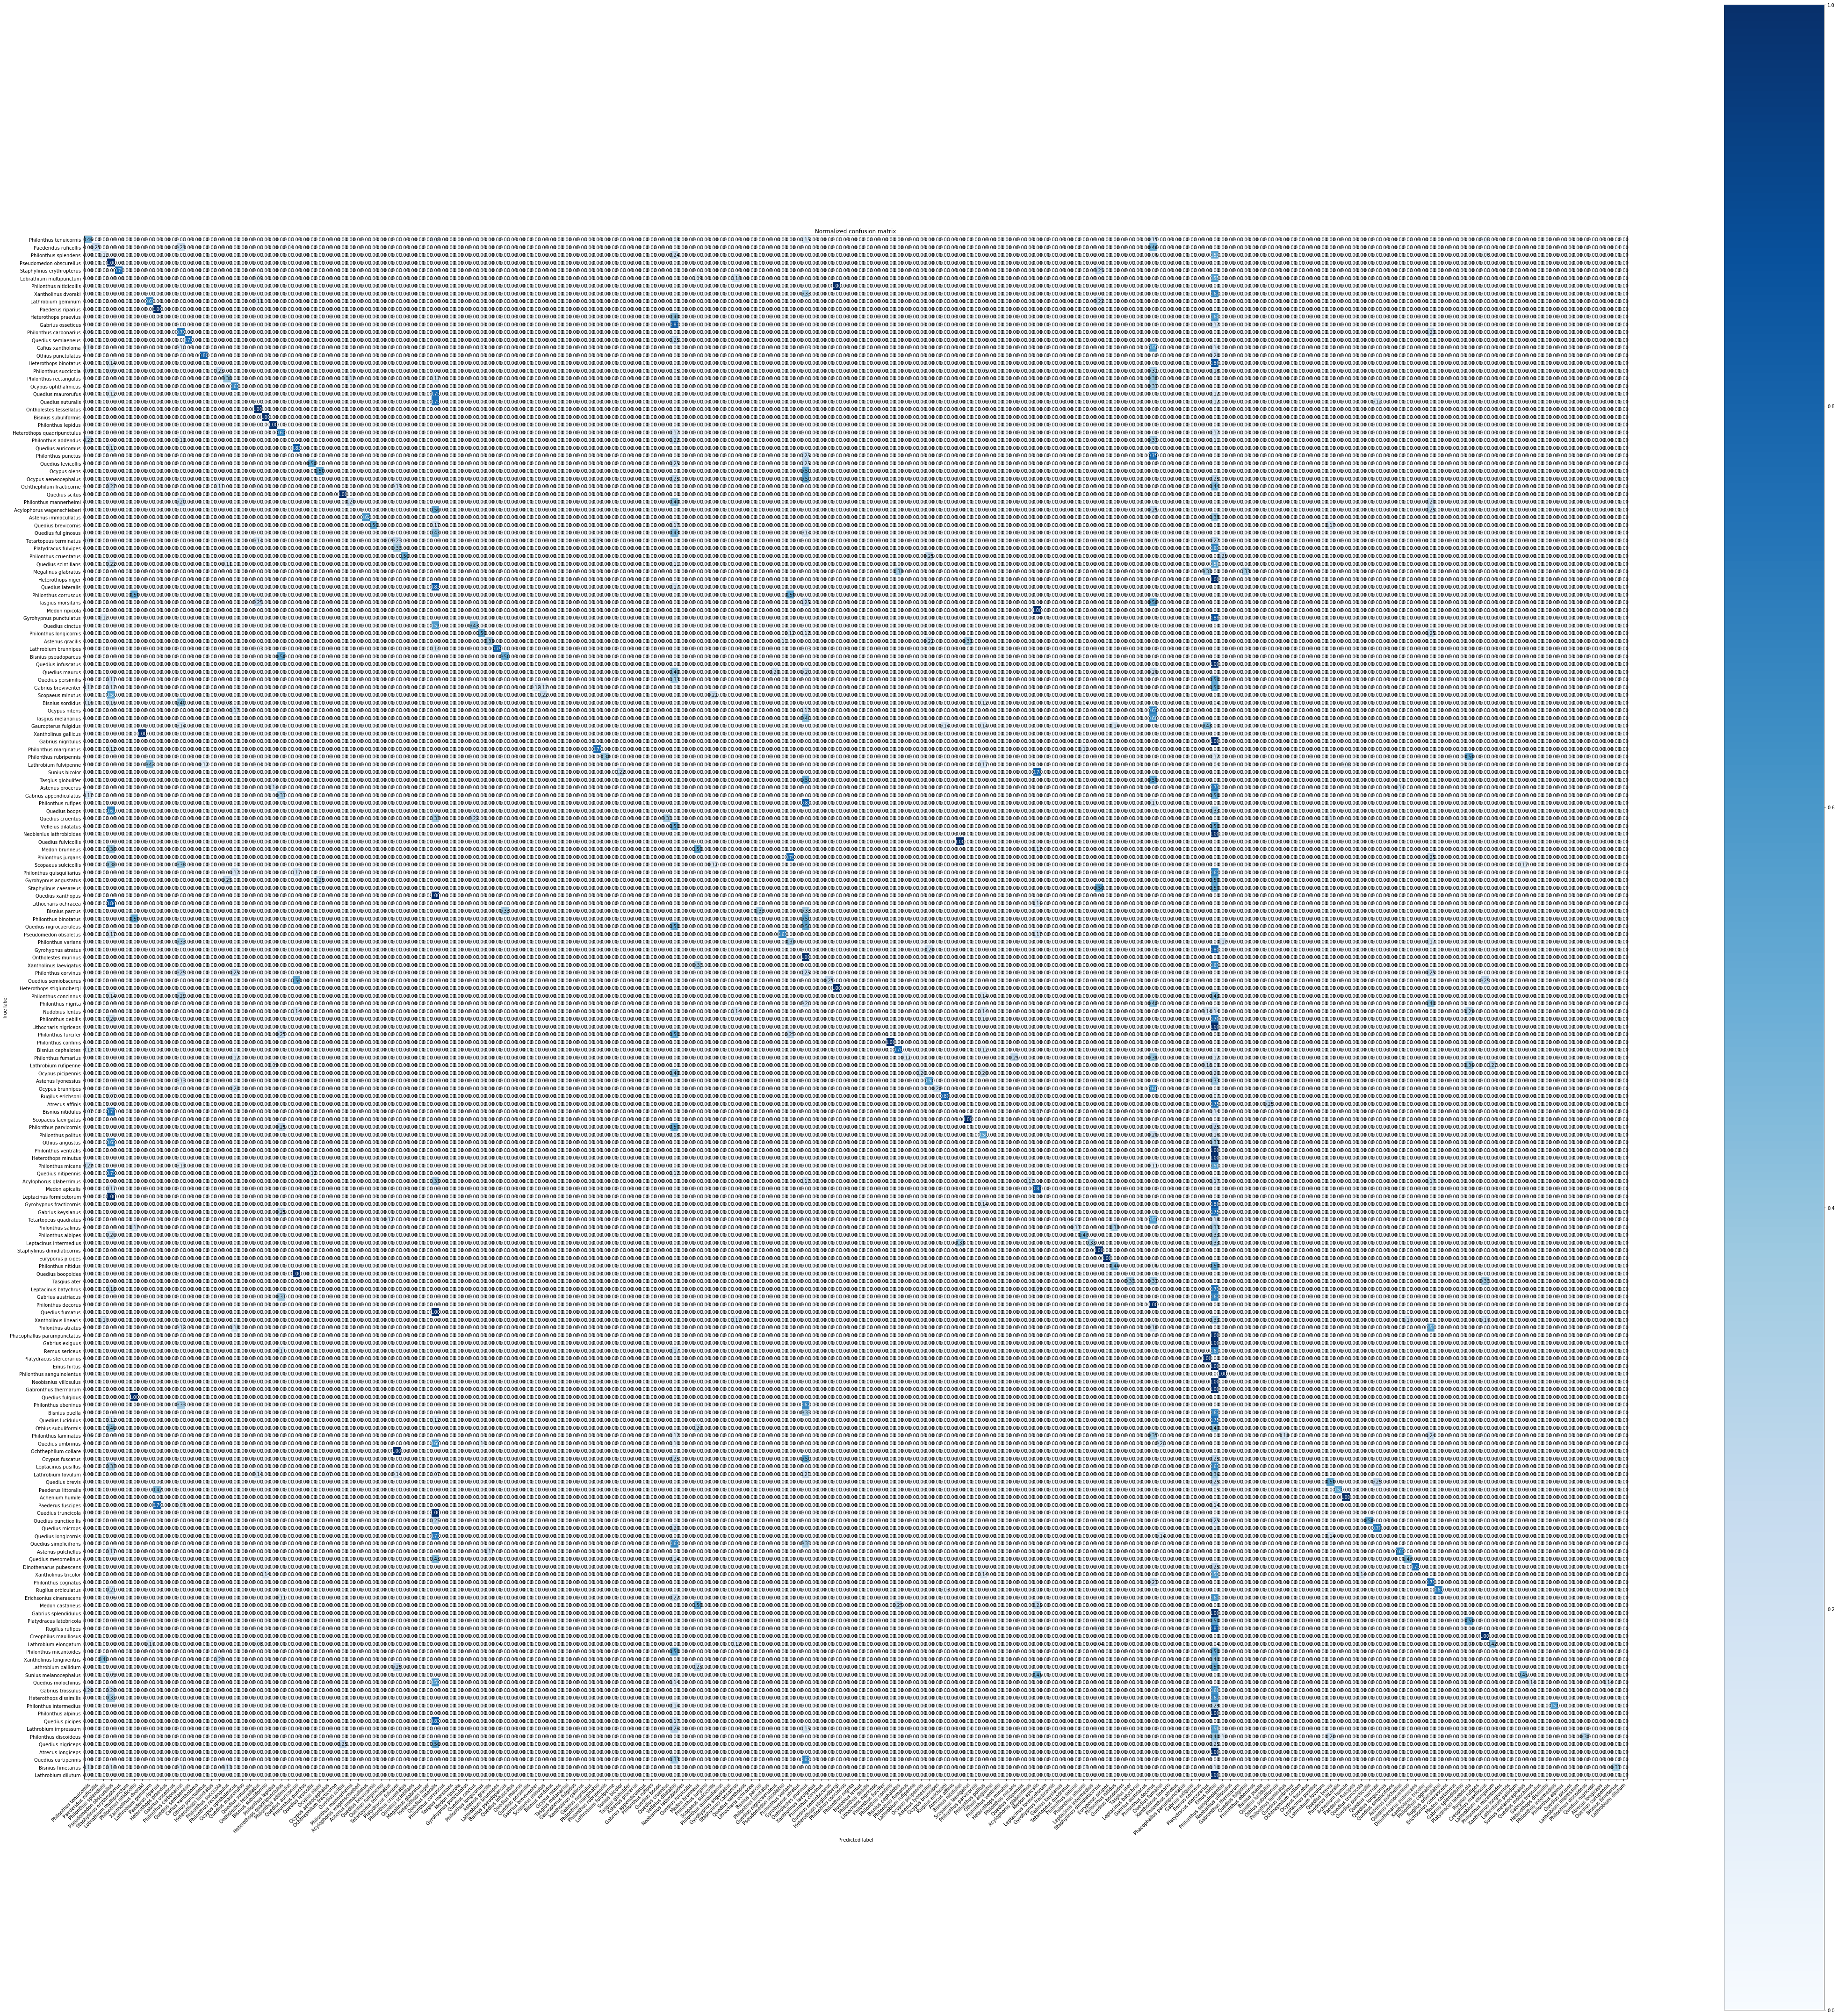

In [12]:
y_true = val_generator.classes
matplotlib.rcParams['figure.figsize'] = [60, 60]
fig, ax = plot_confusion_matrix(y_true, y_pred, np.array(labels), normalize=True)
fig.savefig(confusion_matrix_path)

In [13]:
labels = (val_generator.class_indices) # dict of label:index
labels = dict((i,l) for l,i in labels.items()) # dict of index:label

In [14]:
# create pd.dataframe and save predictions to .csv
filenames=[datasetDir + name for name in val_generator.filenames]
y_pred_labels = [labels[y] for y in y_pred]
y_true_labels = [labels[y] for y in y_true]
y_pred3_labels = []
for i,top3 in enumerate(y_pred3):
    l = []
    for top in top3:
        l.append((labels[top], Y_pred[i][top]))
    y_pred3_labels.append(l)

results=pd.DataFrame({"Filename":filenames,
                      "Label":y_true_labels,
                      "Prediction1":y_pred_labels,
                      "Prediction3":y_pred3_labels})
results.to_csv(results_file,index=True)